In [14]:
%matplotlib inline
from qiskit import Aer, IBMQ, execute
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
hyperparams = [-np.pi/2, 0, -0.979924, -np.pi, 0, np.pi, np.pi, np.pi]
simulator = Aer.get_backend('statevector_simulator')

In [16]:
def fresh_circuit(theta):
    # Construct quantum circuit
    circ = QuantumCircuit(4)
    circ.ry(theta[0],0)
    circ.ry(theta[1],1)
    circ.ry(theta[2],2)
    circ.ry(theta[3],3)
    circ.cx(0,1)
    circ.cx(1,2)
    circ.cx(2,3)
    circ.ry(theta[4],0)
    circ.ry(theta[5],1)
    circ.ry(theta[6],2)
    circ.ry(theta[7],3)
    return circ

In [17]:
def get_sigma(basis,index, result_noise):
    if basis == 'x':
        result = result_noise[0]
    elif basis == 'y':
        result = result_noise[1]
    elif basis == 'z':
        result = result_noise[2]

    vec = np.array([(-1)**(sum([int(n[i]) for i in index])) for n in result.keys()])
    result = np.array(list(result.values()))
    return (np.dot(result,vec))


In [18]:
def calc_H(p):
    circ_z = fresh_circuit(p)
    circ_x = fresh_circuit(p)
    circ_x.h([0, 1, 2, 3])
    circ_y = fresh_circuit(p)
    circ_y.sdg([0, 1, 2, 3])
    circ_y.h([0, 1, 2, 3])
    # Execute noisy simulation and get counts
    result_noise = execute([circ_x, circ_y, circ_z], simulator).result().get_counts()
    # reverse the order of qubits to something that makes sense
    rn = list(map(lambda x: dict(zip(list(map(lambda y: y[::-1], x.keys())), x.values())), result_noise))
    H = get_sigma('z', [0, 2], rn) + 0.372678 * (get_sigma('x', [0, 1], rn) + get_sigma('y', [0, 1], rn) + get_sigma('x', [2, 3], rn) + get_sigma('y',[2, 3],rn))
    return (H)
    """
    try:
        w.writerow(np.append(deltas[i], [H]))
    except:
        print("Didn't add " + params[i])
    """

In [19]:
deg = np.pi/180
lb=-1.5*deg
ub=1.5*deg
deltas = np.mgrid[lb:ub:5j, lb:ub:5j, lb:ub:5j, lb:ub:5j, lb:ub:5j, lb:ub:5j, lb:ub:5j, lb:ub:5j].reshape(8,-1).T
params = np.array(list(map( lambda x: x+hyperparams,deltas)))
results = np.zeros((len(deltas),1), dtype=np.float64)
for i in range(len(deltas)):
    results[i] = calc_H(params[i])
df = pd.DataFrame(np.append(deltas, results, axis=1),columns=['dth'+str(i) for i in range(1,9)]+['H'])
df.to_csv('statevector_results_real.csv',index=False)

In [3]:
df = pd.read_csv('simulator_results.csv')

In [20]:
df

dth1     dth2     dth3     dth4     dth5     dth6     dth7  \
0      -0.02618 -0.02618 -0.02618 -0.02618 -0.02618 -0.02618 -0.02618   
1      -0.02618 -0.02618 -0.02618 -0.02618 -0.02618 -0.02618 -0.02618   
2      -0.02618 -0.02618 -0.02618 -0.02618 -0.02618 -0.02618 -0.02618   
3      -0.02618 -0.02618 -0.02618 -0.02618 -0.02618 -0.02618 -0.02618   
4      -0.02618 -0.02618 -0.02618 -0.02618 -0.02618 -0.02618 -0.02618   
...         ...      ...      ...      ...      ...      ...      ...   
390620  0.02618  0.02618  0.02618  0.02618  0.02618  0.02618  0.02618   
390621  0.02618  0.02618  0.02618  0.02618  0.02618  0.02618  0.02618   
390622  0.02618  0.02618  0.02618  0.02618  0.02618  0.02618  0.02618   
390623  0.02618  0.02618  0.02618  0.02618  0.02618  0.02618  0.02618   
390624  0.02618  0.02618  0.02618  0.02618  0.02618  0.02618  0.02618   

           dth8         H  
0      -0.02618 -1.793554  
1      -0.01309 -1.793508  
2       0.00000 -1.793407  
3       0.01309 -1.793252  
4       0.02618 -1.793044  
...         ...       ...  
390620 -0.02618 -1.792996  
390621 -0.01309 -1.793201  
390622  0.00000 -1.793355  
390623  0.01309 -1.793457  
390624  0.02618 -1.793506  

[390625 rows x 9 columns]

array([[<AxesSubplot:title={'center':'H'}>]], dtype=object)

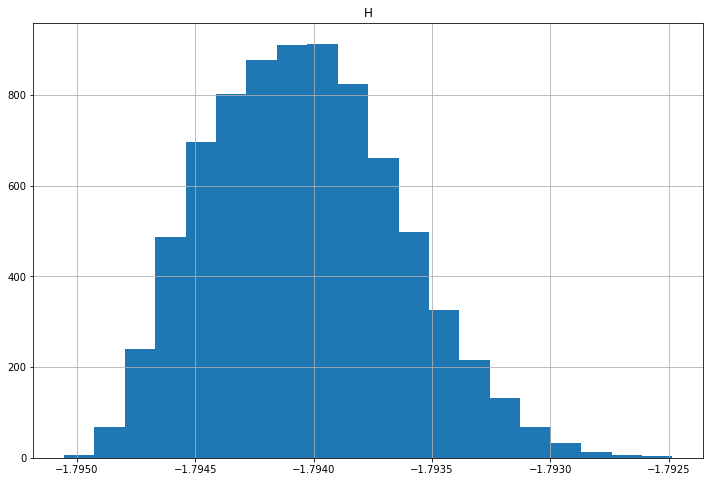

In [30]:
df.hist(column='H', bins=20, grid=True, figsize=(12,8), density=True)

<BarContainer object of 20 artists>

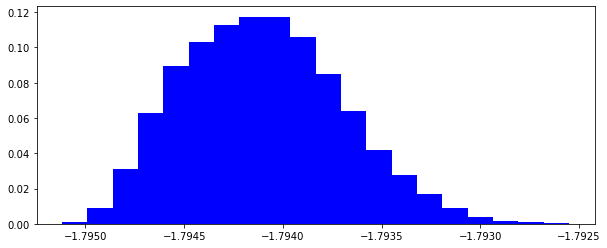

In [29]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
hist, bins = np.histogram(df.H, bins=20)
ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='blue')


In [ ]:
import numdifftools as nd
Hfun = nd.Hessian(calc_H)
x = Hfun(hyperparams)
evals, evecs = np.linalg.eig(x)